This is one that came up recently on the [mailing list](https://www.mail-archive.com/rdkit-discuss@lists.sourceforge.net/msg09570.html) that I thought merited a quick post.


In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import rdkit
print(rdkit.__version__)

2022.03.1


In [3]:
import itertools
def getAromaticRings(mol):
    ' generator returning all aromatic rings (=only aromatic bonds) in a molecule'
    ri = mol.GetRingInfo()
    for ring in ri.BondRings():
        ats = set()
        isArom = True
        for bi in ring:
            bnd = mol.GetBondWithIdx(bi)
            if not bnd.GetIsAromatic():
                isArom = False
                break
            ats.add(bnd.GetBeginAtomIdx())
            ats.add(bnd.GetEndAtomIdx())
        if isArom:
            yield ats
def getSharedRings(mol,queries,rings=None):
    ''' generator returning all rings that contain all the atoms defined in queries 
        the first atom matching each query should be in the ring
        if the argument rings isn't provided, this will just use all rings in
        the molecule
    '''
    if rings is None:
        rings = mol.GetRingInfo().AtomRings()
    rings = [set(x) for x in rings]
    matchSets = [[x[0] for x in mol.GetSubstructMatches(q)] for q in queries]
    for combo in itertools.product(*matchSets):
        scombo = set(combo)
        if len(scombo) < len(combo):
            # degenerate:
            continue
        for ring in rings:
            if scombo.issubset(ring):
                yield ring

def drawMolWithRings(mol,rings):
    bondsToHighlight=[]
    for bnd in mol.GetBonds():
        keep = False
        ats = set([bnd.GetBeginAtomIdx(),bnd.GetEndAtomIdx()])
        for ring in rings:
            if ats.issubset(ring):
                keep = True
                break
        if keep:
            bondsToHighlight.append(bnd.GetIdx())
    highlightAtoms = list(itertools.chain.from_iterable(rings))

    tmol = Draw.PrepareMolForDrawing(mol)
    d2d = Draw.MolDraw2DCairo(300, 250)
    d2d.DrawMolecule(tmol, highlightAtoms=highlightAtoms, 
                     highlightBonds = bondsToHighlight)
    d2d.FinishDrawing()
    return Draw._drawerToImage(d2d)

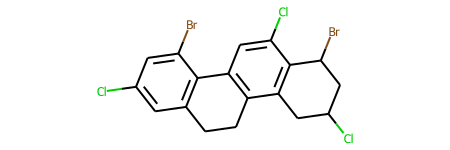

In [4]:
mol = Chem.MolFromSmiles('c1c(Cl)cc(Br)c2c1CCc3c2cc(Cl)c4c3CC(Cl)CC4Br')
ri = mol.GetRingInfo()
mol

In [5]:
[x for x in getAromaticRings(mol)]

[{0, 1, 3, 4, 6, 7}, {10, 11, 12, 13, 15, 16}]

[{0, 1, 3, 4, 6, 7}]


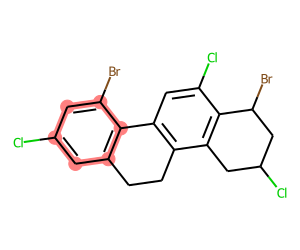

In [6]:
matches = list(getSharedRings(mol,[Chem.MolFromSmarts(sma) for sma in ('[a]-Cl','[a]-Br')],
                              rings=getAromaticRings(mol)))
print(matches)
drawMolWithRings(mol,matches)

[{0, 1, 3, 4, 6, 7}, {16, 10, 11, 12, 13, 15}, {16, 10, 11, 12, 13, 15}, {16, 10, 11, 12, 13, 15}]


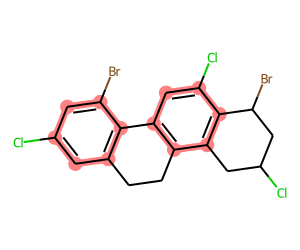

In [7]:
matches = list(getSharedRings(mol,[Chem.MolFromSmarts(sma) for sma in ('[a]-Cl','[a]-C')],
                             rings=getAromaticRings(mol)))
print(matches)
drawMolWithRings(mol,matches)

What about just finding any rings that have both Cl and Br connected?

[{0, 1, 3, 4, 6, 7}, {15, 16, 17, 18, 20, 21}]


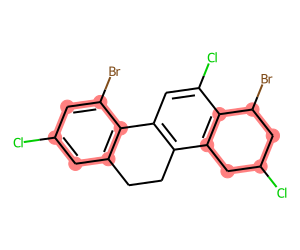

In [8]:
matches = list(getSharedRings(mol,[Chem.MolFromSmarts(sma) for sma in ('[*]-Cl','[*]-Br')]))
print(matches)
drawMolWithRings(mol,matches)